In the [previous post](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/Bayesian%20Modeling%20for%20Oceanographers%20-%202%20-%20Inference%20using%20OC4.ipynb) post, I showed how to build a number of bayesian regression models around the classic OC4 algorithm for estimating chlorophyll concentration from remote sensing reflectance data.

In this post I will introduce several concepts as needed. These include:
* hierarchical models sometimes referred to as multilevel or partially pooled models,
* varying effects,
* gaussian processes to introduce inference on potential covariance between unobserved variables (parameters).

In [1]:
import pickle
# Importing libraries
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, kdeplot
import theano.tensor as tt

In [2]:
# Setting graphics...
% matplotlib inline
pl.style.use('bmh')
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['figure.titlesize'] = 20
rcParams['axes.titlesize'] = 18

Load the training dataset. The rrs data was imputed where necessary from adjacent bands, either by direct assignment or via linear modeling (regression). This step can be found [here](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/DataPrep-2-Developing_imputation_models_for_missing_data.ipynb).

In [3]:
df = pd.read_pickle('./pickleJar/df_log.pkl')

In [4]:
df.head().T

,0,1,2,3,4
id,4045,4056,4057,5949,5950
datetime,1998-08-29 17:55:00,1998-09-02 15:52:00,1998-09-02 18:10:00,1997-10-12 23:38:00,1997-10-13 18:33:00
lat,60.587,60.674,60.604,59.118,58.792
lon,-146.409,-147.682,-147.205,-148.677,-148.493
etopo2_l,1.91381,1.14613,2.02938,2.15534,2.45637
oisst,13.04,11.74,11.74,9.71,9.84
sal_l,NaN,NaN,NaN,NaN,NaN
rrs411_l,-2.48181,-2.69759,-2.57346,-2.74698,-2.85684
rrs443_l,-2.39369,-2.57914,-2.48391,-2.66945,-2.77425
rrs489_l,-2.32961,-2.44558,-2.39021,-2.56902,-2.6778


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 0 to 4458
Data columns (total 36 columns):
id              4459 non-null object
datetime        4459 non-null datetime64[ns]
lat             4459 non-null float64
lon             4459 non-null float64
etopo2_l        4459 non-null float64
oisst           4459 non-null float64
sal_l           2511 non-null float64
rrs411_l        4293 non-null float64
rrs443_l        4456 non-null float64
rrs489_l        4422 non-null float64
rrs510_l        4207 non-null float64
rrs555_l        4453 non-null float64
rrs670_l        3822 non-null float64
mxBl_l          4459 non-null float64
mxBlId          4459 non-null object
mxBlCat         4459 non-null int8
mxBlColor       4459 non-null object
mxBl2_l         4459 non-null float64
mxBl2Id         4459 non-null object
mxBl2Cat        4459 non-null int8
mxBl2Color      4459 non-null object
provCode        4459 non-null object
provCat         4459 non-null int64
provColor       4459 non-n

/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


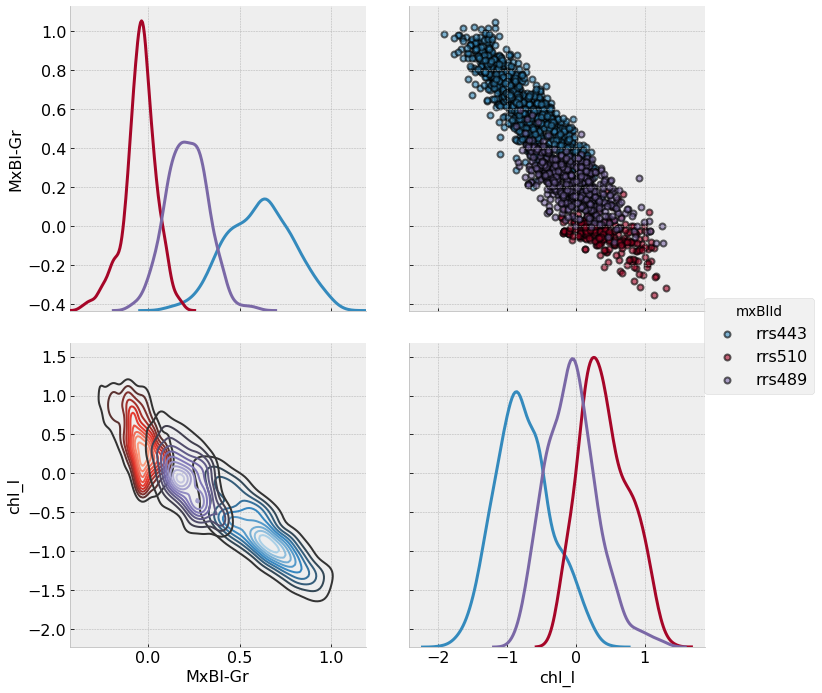

In [7]:
g = PairGrid(df.dropna(), vars=['MxBl-Gr', 'chl_l'], size=5, diag_sharey=False,
             hue='mxBlId',
             hue_kws={"cmap": ["Blues_d", "Reds_d", "Purples_d"]});
g = g.map_upper(pl.scatter,alpha=0.6, edgecolor='k', linewidth=2)
g = g.map_diag(kdeplot, lw=3)
g = g.map_lower(kdeplot);
g.add_legend();

The first thing that we can see from the imputation of the data, documented in an [earlier notebook](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/DataPrep-2-Developing_imputation_models_for_missing_data.ipynb), is that the pattern in the data no longer supports necessarily a high order polynomial such as OC4. Instead, I will model the band contribution as a simpler and more readily interpretable first order regression on $log(max(blue)) - log(green)$.
<br>
The data also shows good separability with respect to the blue band used in the ratio; both in terms of chlorophyll and band ratio distributions.<br> This clustering scheme can be used to add information to the data fit. As such it will be part of the hierarchical model architecture presented below.
<br>
Another source of information that can be used for clustering is location. A simple and familiar scheme that can be used is Longhurst biogeographical province distribution.
 For context, the Longhurst map looks as follows:
<img src='figJar/lhurstbiogeog.jpg'>
<br>
An exploratory plot depicting the data distribution by province is available here.

The relationship of the various models proposed with chl_l, including the legacy OC4 algorithm, given the new augmented dataset fail to justify anything but a one degree polynomial. Another motivation to refrain from compounding the predictor variables is the interpretability the associated model parameters, the interpretability of which thus remains feasible. This does not preclude having to deal with potentially complicated relationships between predictor and predicted variables. A better way to address complexity is to use more predictor variables, and increase the flexibility of the models tested by using clustering within the data. Such flexibility can be achieved with the use of hierarchical models.

### Bayesian Hierarchical Models

Quoting from Betancourt & Girolami (2013):
"Hierarchical models are defined by the organization of a model's parameters into exchangeable groups, and the resulting conditional independencies between those groups."

Inference in a hierarchical model is conducted on multiple levels with cluster-specific parameters  with one or more common priors,  referred to as *hyper-priors*. Hyper-priors constitute a link through which information between clusters can flow during model fitting.

Structurally, and unlike models seen in [the earlier post](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/Bayesian%20Modeling%20for%20Oceanographers%20-%202%20-%20Inference%20using%20OC4.ipynb), hierarchical models have:

    * one set of priors for each cluster
    * a common set of priors for the cluster priors. These hyperpriors are the constructs that allow information to flow between the different clusters.

I will illustrate the above with a diagram for the models. As shown above, there are three clusterings to choose from, including *mxblID*, *biome*, and *province*. Based on earlier diagnostics I will use *mxblID* and *province*. Note that even when max(blue) is not included in the predictor variable used, it still represent a potentially important piece of information on each observation. I therefore include it regardless of the model being fit.


### Varying intercepts models

Below is a diagram depicting a hierachical model, where the linear regression includes a cluster-specific intercepts. **Varying intercept** (hereafter VI) models, these models a cluster specific-baseline (in this case in chlorophyll) while assuming a sufficently unique as to be common relationship to the predictor variables, represented by single slope parameters. 

In [24]:
df.head().T

,0,1,2,3,4
id,4045,4056,4057,5949,5950
datetime,1998-08-29 17:55:00,1998-09-02 15:52:00,1998-09-02 18:10:00,1997-10-12 23:38:00,1997-10-13 18:33:00
lat,60.587,60.674,60.604,59.118,58.792
lon,-146.409,-147.682,-147.205,-148.677,-148.493
etopo2_l,1.91381,1.14613,2.02938,2.15534,2.45637
oisst,13.04,11.74,11.74,9.71,9.84
sal_l,NaN,NaN,NaN,NaN,NaN
rrs411_l,-2.48181,-2.69759,-2.57346,-2.74698,-2.85684
rrs443_l,-2.39369,-2.57914,-2.48391,-2.66945,-2.77425
rrs489_l,-2.32961,-2.44558,-2.39021,-2.56902,-2.6778


In [36]:
# getting relevant data:
d_ = df[['provCat', 'mxBlCat', 'MxBl-Gr', 'chl_l']].dropna()
print(d_.shape)

(4126, 4)


In [41]:
d_.describe()

,provCat,mxBlCat,MxBl-Gr,chl_l
count,4126.000000,4126.000000,4126.000000,4126.000000
mean,17.384149,0.873243,0.273775,-0.112434
std,13.943419,0.828391,0.314858,0.688037
min,0.000000,0.000000,-0.398402,-1.920819
25%,2.000000,0.000000,0.009346,-0.632342
50%,10.000000,1.000000,0.251213,-0.116825
75%,31.000000,2.000000,0.515516,0.332438
max,44.000000,2.000000,1.079671,1.891341


In [38]:
n_provinces = d_.provCat.unique().size
n_blues = d_.mxBlCat.unique().size
provIdx = d_.provCat.values
blueIdx = d_.mxBlCat.values
predictor = d_['MxBl-Gr'].values
predicted = d_['chl_l'].values
with pm.Model() as vi_1:
    # hyper-priors
    sigma_blue = pm.HalfCauchy('sigma_blue', 1)
    sigma_province = pm.HalfCauchy('sigma_province', 1)
    #priors
    sigma_model = pm.HalfCauchy('sigma_model', 1)
    a = pm.Normal('a', 0, 10) # global intercept
    a_blue = pm.Normal('a_blue', 0, sigma_blue, shape=n_blues) # mxblue intercept
    a_province = pm.Normal('a_prov', 0, sigma_province, shape=n_provinces) # prov. icpt.
    slope = pm.Normal('slope', 0, 10)
    mu = a + a_blue[blueIdx] + a_province[provIdx] + slope * predictor
    likelihood = pm.Normal('log_chl', mu=mu, sd=sigma_model, observed=predicted)

In [ ]:
with vi_1:
    trace_vi_1 = pm.sample(10000, tune=2000, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, a_prov, a_blue, a, sigma_model_log__, sigma_province_log__, sigma_blue_log__]
100%|██████████| 12000/12000 [07:42<00:00, 25.94it/s]


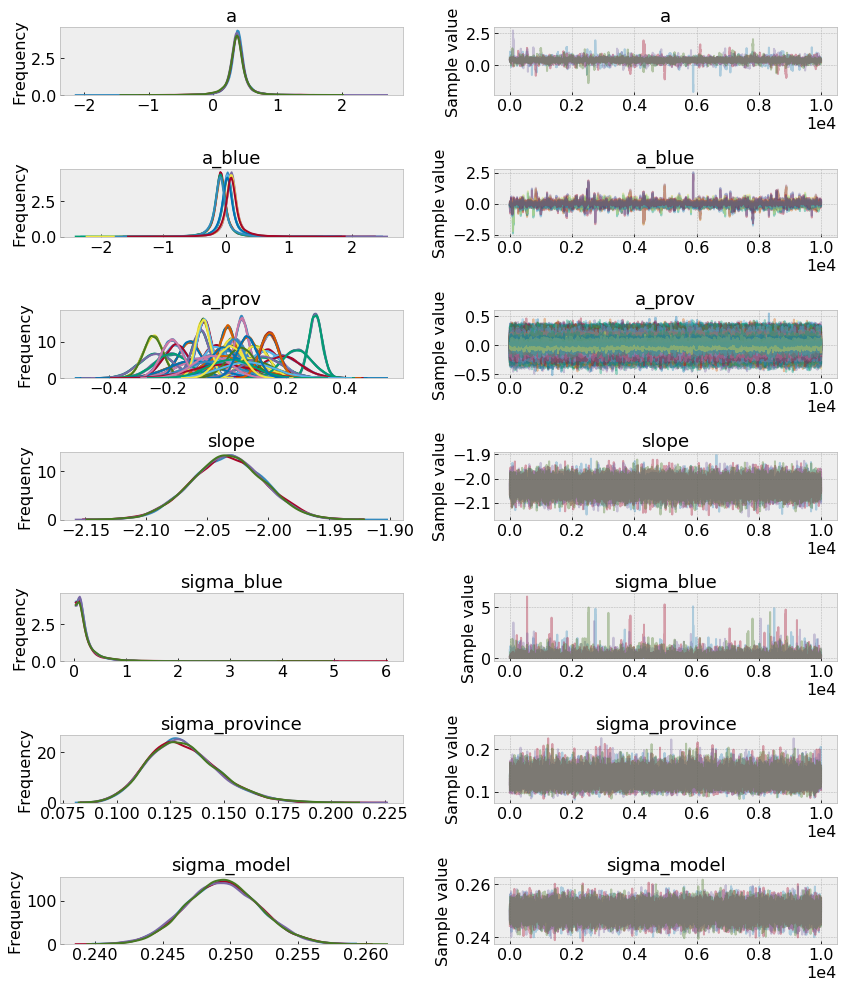

In [40]:
pm.traceplot(trace_vi_1);

### Varying effects models

### Comparing models

In this section I compare the models fit so far, including those saved from the [previous post](https://github.com/madHatter106/Bayesian-Chlorophyll/blob/master/Bayesian%20Modeling%20for%20Oceanographers%20-%202%20-%20Inference%20using%20OC4.ipynb). First, I load the latter, which include the legacy oc4 fit, a $4^{th}$ order polynomial regression,  and a simpler $3^{rd}$ order polynomial regression ...

In [275]:
with open('./pickleJar/models.pkl', 'rb') as fmod:
    pooled_mdl_dict = pickle.load(fmod)

pooled_mdl_dict['models'].keys()

dict_keys(['oc4', 'oc4_3'])

In [67]:
with pm.Model() as m_ve:
    #hyper-priors
    mu_alpha = pm.Normal('mu_alpha', mu=0, sd=10)
    sig_alpha = pm.HalfCauchy('sig_alpha', 2)
    mu_beta = pm.Normal('mu_beta', mu=0, sd=10)
    sig_beta = pm.HalfCauchy('sig_beta', 2)
    
    # priors
    alpha_offset = pm.Normal('alpha_offset', mu=0, sd=1, shape=n_clusters)
    beta_offset = pm.Normal('beta_offset', mu=0, sd=1, shape=n_clusters)
    alpha_nc = pm.Deterministic('alpha_nc', mu_alpha + alpha_offset * sig_alpha)
    beta_nc = pm.Deterministic('beta_nc', mu_beta + beta_offset * sig_beta)
    sigma = pm.HalfCauchy('sigma', 2)
    nu_ = pm.HalfCauchy('nu', 5)
    # deterministic form of the model
    mu_ = alpha_nc[clust_idx] + beta_nc[clust_idx] * df_train.mxBl2Gr.values
    
    # likelihood
    chlor_a = pm.StudentT('chlor_a', nu=nu_, mu=mu_, sd=sigma, observed=df_train.chlor_a.values)
    
    # sample
    trace_m_ve = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_log__, sigma_log__, beta_offset, alpha_offset, sig_beta_log__, mu_beta, sig_alpha_log__, mu_alpha]
100%|██████████| 6000/6000 [04:40<00:00, 21.41it/s]
Divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.666270709659, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Divergences after tuning. Increase `ta

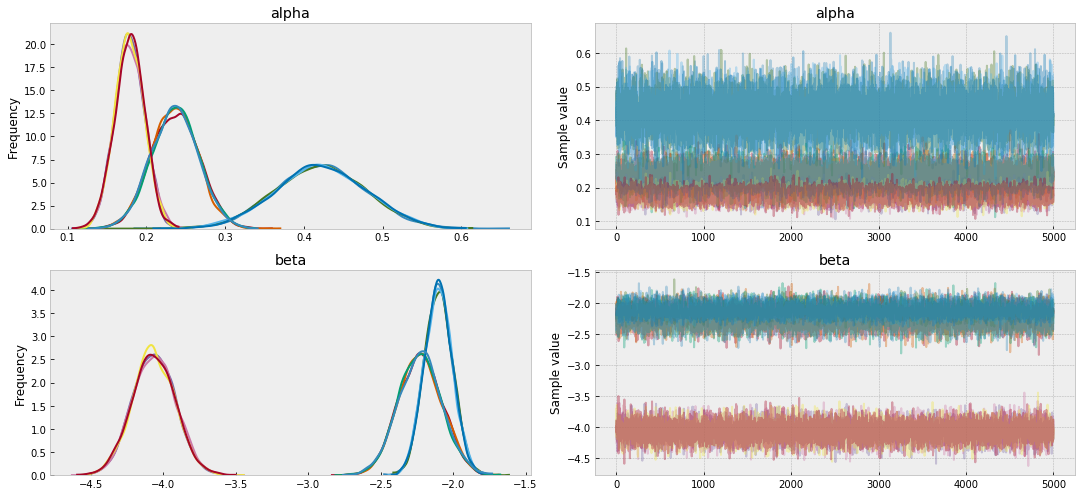

In [34]:
pm.traceplot(trace_m_ve, varnames=['alpha', 'beta'], figsize=(15, 7));

In [47]:
pm.summary(trace_m_ve, varnames=['alpha', 'beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,0.421201,0.057557,0.000469,0.306911,0.531422,13793.0,0.999959
alpha__1,0.235754,0.029852,0.000257,0.175900,0.292583,14149.0,0.999948
alpha__2,0.178563,0.018836,0.000140,0.142702,0.216388,15454.0,0.999932
beta__0,-2.101171,0.096530,0.000767,-2.283403,-1.908664,13956.0,0.999971
beta__1,-2.228004,0.149608,0.001342,-2.525108,-1.939888,14075.0,0.999987
beta__2,-4.067230,0.146652,0.001143,-4.360344,-3.788972,15118.0,0.999923


In [52]:
m_oc4 = pooled_mdl_dict['models']['oc4']
m_oc4_3 = pooled_mdl_dict['models']['oc4_3']
trace_oc4 = pooled_mdl_dict['traces']['oc4']
trace_oc4_3 = pooled_mdl_dict['traces']['oc4_3']

In [55]:
traces_so_far = [trace_oc4, trace_oc4_3, trace_m_vi, trace_m_ve]
models_so_far = [m_oc4, m_oc4_3, m_vi, m_ve]
model_names = ['pooled_poly_4', 'pooled_poly_3', 'var_intcepts', 'var_eff']
df_comp = pm.compare(traces=traces_so_far, models=models_so_far)
df_comp.index = [model_names[i] for i in df_comp.index]
df_comp.iloc[:,:-1]

,WAIC,pWAIC,dWAIC,weight,SE,dSE
pooled_poly_4,379.52,5.56,0,0,56.46,0
pooled_poly_3,380.38,4.76,0.86,0.85,56.6,3.19
var_eff,387.29,8.96,7.77,0,52.34,15.79
var_intcepts,513.07,5.3,133.55,0.15,45.58,34.28


<u>Refs:</u>

[1.](https://arxiv.org/abs/1312.0906) Betancourt, M. & Girolami, M. 2013. Hamiltonian Monte Carlo for Hierarchical Models. [arXiv:1312.0906](https://arxiv.org/abs/1312.0906)